In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/processed/cars_clean.csv')
print(f"updated types:\n{df.dtypes}\n")
print(f"updated missing values counts:\n{df.isnull().sum()}\n")
print(f"data columns: {df.columns}\n")

# best choice: frequency encoding
print(f"unique man ids: {df['manufacturer'].nunique()}")
print(f"unique model ids: {df['model'].nunique()}")

freq_manufacturer = df['manufacturer'].value_counts(normalize=True)
df['manufacturer_freq'] = df['manufacturer'].map(freq_manufacturer)

freq_model = df['model'].value_counts(normalize=True)
df['model_freq'] = df['model'].map(freq_model)

df = df.drop(columns=['manufacturer', 'model'])

# best choice: one hot encoding
print(f"unique fuel types: {df['fuel_type'].nunique()}")
print(f"unique gear types: {df['gear_type'].nunique()}")
print(f"unique drive types: {df['drive_type'].nunique()}")
print(f"unique color types: {df['color'].nunique()}")
print(f"unique car categories: {df['category'].nunique()}")

categorical_cols = ['fuel_type', 'gear_type', 'drive_type', 'color', 'category']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


updated types:
car_id                     int64
price                    float64
car_age                    int64
engine_volume            float64
cylinders                  int64
car_run_km               float64
safety_feature_count       int64
comfort_feature_count      int64
manufacturer              object
model                     object
fuel_type                 object
gear_type                 object
drive_type                object
color                     object
category                  object
abs                        int64
esd                        int64
el_windows                 int64
conditioner                int64
leather                    int64
hydraulics                 int64
chair_warming              int64
climat_control             int64
customs_passed             int64
tech_inspection            int64
has_turbo                  int64
right_wheel                int64
start_stop                 int64
back_camera                int64
is_dealer                  i

In [45]:
df = df.drop(columns=['car_id'])
X = df.drop(columns=['price'])
y = df['price']

# need this for later
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [46]:
def train_with_linear_reg(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_with_lasso(X_train, y_train):
    model = Lasso()
    model.fit(X_train, y_train)
    return model

def train_with_ridge(X_train, y_train):
    model = Ridge()
    model.fit(X_train, y_train)
    return model

def train_with_decision_tree(X_train, y_train, max_depth=10):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

def train_with_random_forest(X_train, y_train, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    return model

def predict(X_test, model):
    y_pred = model.predict(X_test)
    return y_pred

def calc_metrics(y_pred, y):
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    return r2, mse, mae, rmse


In [47]:
# Train each model
linear_reg = train_with_linear_reg(X_train, y_train)
lasso = train_with_lasso(X_train, y_train)
ridge = train_with_ridge(X_train, y_train)
decision_tree = train_with_decision_tree(X_train, y_train)
random_forest = train_with_random_forest(X_train, y_train)

# Evaluate results for all models
models = {
    'Linear_Reg': linear_reg,
    'Lasso': lasso,
    'Ridge': ridge,
    'Decision_Tree': decision_tree,
    'RandomForest': random_forest
}

results = []
random_forest_pred = []

for name, model in models.items():
    print(f"Model: {name}")

    # predictions
    y_pred = predict(X_test, model)
    if name == 'RandomForest':
        random_forest_pred = y_pred

    # calculate metrics
    r2, mse, mae, rmse = calc_metrics(y_pred, y_test)

    results.append({
        'Model': name,
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    })

# Comparison Table
results_df = pd.DataFrame(results)
print(f"\n{'='*50}")
print("MODEL COMPARISON TABLE")
print(f"{'='*50}")
print(results_df.to_string(index=False))


Model: Linear_Reg
Model: Lasso
Model: Ridge
Model: Decision_Tree
Model: RandomForest

MODEL COMPARISON TABLE
        Model       R2          MSE         MAE        RMSE
   Linear_Reg 0.489065 4.449066e+07 4251.829630 6670.131733
        Lasso 0.489111 4.448665e+07 4250.192783 6669.831690
        Ridge 0.489069 4.449028e+07 4251.713621 6670.103669
Decision_Tree 0.765135 2.045136e+07 2208.850835 4522.317516
 RandomForest 0.858002 1.236472e+07 1719.441610 3516.350891


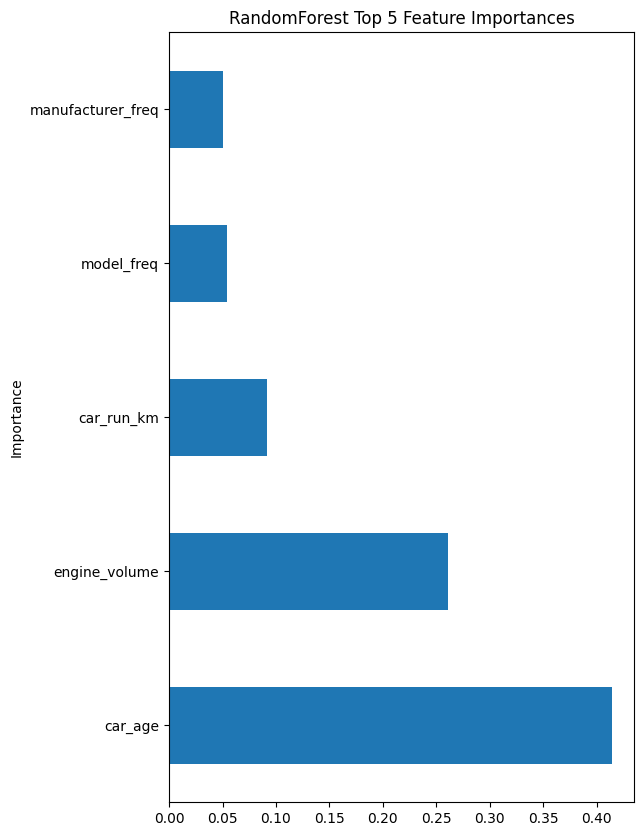

In [48]:
# Feature importance from RandomForest
rf_importance = pd.Series(random_forest.feature_importances_, index=feature_names)
rf_importance = rf_importance.sort_values(ascending=False)

plt.figure(figsize=(6, 10))

rf_importance.head().plot(kind='barh')
plt.title("RandomForest Top 5 Feature Importances")
plt.ylabel("Importance")
plt.show()

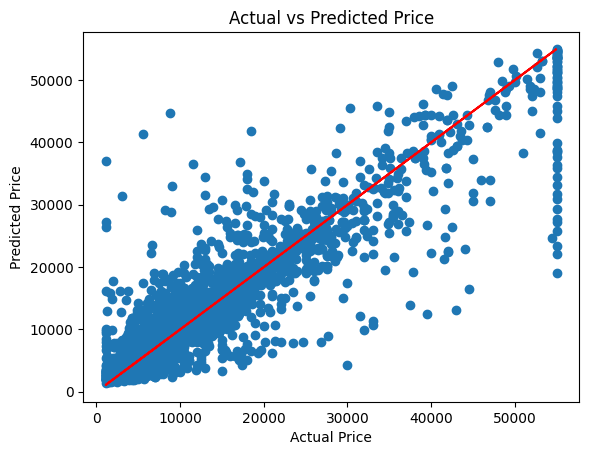

In [49]:
# predicted vs actual price plot

plt.scatter(y_test, random_forest_pred)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [50]:
# save model

import joblib

joblib.dump(model, "../models/random_forest_model.pkl")
joblib.dump(feature_names, "../models/model_features.pkl")


['../models/model_features.pkl']